<a href="https://colab.research.google.com/github/gabsvelozo/banking-customer-prediction/blob/main/An%C3%A1lise_Comparativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto Final
- Conjunto de dados: `churn` ([dataset original](https://github.com/atlantico-academy/datasets/blob/main/churn.csv))
- Cientistas de dados:
  - Gabrielle Mastellari Velozo (gabsmastellari@gmail.com)
  - Lívia Lorrani Florêncio Dos Santos (livialorrani.s@gmail.com)
  - Tamires Paulino Chaves (tamirespaulino68@gmail.com)
---

# Análise comparativa de modelos


---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pipelines e transformadores
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

# codificação de variáveis
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

# normalização
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# dados faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# modelagem
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# @title Leitura do conjunto de dados
df = pd.read_csv("https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/churn.csv")

In [ ]:
# @title Criação do dicionário de dados

df_dict = pd.DataFrame([
    {
        "variavel": "CreditScore",
        "descricao": "Pontuação de crédito do cliente.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "Geography",
        "descricao": "País de residência do cliente.",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "Gender",
        "descricao": "Gênero do cliente (Male/Female).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "Age",
        "descricao": "Idade do cliente.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "Tenure",
        "descricao": "Tempo de permanência como cliente (em anos).",
        "tipo": "quantitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "Balance",
        "descricao": "Saldo bancário do cliente.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "NumOfProducts",
        "descricao": "Número de produtos adquiridos pelo cliente.",
        "tipo": "quantitativa",
        "subtipo": "discreta",
    },
    {
        "variavel": "HasCrCard",
        "descricao": "Se o cliente possui cartão de crédito (1 = Sim, 0 = Não).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "IsActiveMember",
        "descricao": "Se o cliente é um membro ativo (1 = Sim, 0 = Não).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "EstimatedSalary",
        "descricao": "Salário estimado do cliente.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "Exited",
        "descricao": "Se o cliente saiu do banco (1 = Sim, 0 = Não).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "Surname",
        "descricao": "Sobrenome do cliente.",
        "tipo": "inútil",
        "subtipo": "inútil",
    },
    {
        "variavel": "CustomerId",
        "descricao": "Número de identificação do cliente.",
        "tipo": "inútil",
        "subtipo": "inútil",
    },
    {
        "variavel": "RowNumber",
        "descricao": "Número da linha com os dados do cliente.",
        "tipo": "inútil",
        "subtipo": "inútil",
    },
])
df_dict

,variavel,descricao,tipo,subtipo
0,CreditScore,Pontuação de crédito do cliente.,quantitativa,contínua
1,Geography,País de residência do cliente.,qualitativa,nominal
2,Gender,Gênero do cliente (Male/Female).,qualitativa,nominal
3,Age,Idade do cliente.,quantitativa,contínua
4,Tenure,Tempo de permanência como cliente (em anos).,quantitativa,ordinal
5,Balance,Saldo bancário do cliente.,quantitativa,contínua
6,NumOfProducts,Número de produtos adquiridos pelo cliente.,quantitativa,discreta
7,HasCrCard,Se o cliente possui cartão de crédito (1 = Sim...,qualitativa,nominal
8,IsActiveMember,"Se o cliente é um membro ativo (1 = Sim, 0 = N...",qualitativa,nominal
9,EstimatedSalary,Salário estimado do cliente.,quantitativa,contínua


In [ ]:
# @title Seleção de variáveis e separação de entradas e saídas
target_variable = ['Exited']

useless_variables = (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

unused_variables = useless_variables + target_variable

nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

X = df.drop(columns=unused_variables)
y = df[target_variable]


## Preparação de dados

Cada um dos tipos de variáveis foi submetido a um fluxo de tratamento de dados específico, a saber:

### Variáveis quantitativas
 - **Contínuas**: imputação de valores faltantes através da média e normalização min-max.
 - **Discretas**: imputação de valores faltantes através da mediana e normalização min-max.

### Variáveis qualitativas
 - **Ordinais**: imputação de valores faltantes através da moda e codificação via *one-hot encoding*.
 - **Nominais**: imputação de valores faltantes a partir do valor mais frequente e codificação ordinal de valores.

In [ ]:
# variáveis discretas
discrete_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='median')), # tratamento de dados faltantes
    # tratamento de dados discrepantes
    ("normalization",  MinMaxScaler())# normalização
])
# variáveis contínuas
continuous_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')), # tratamento de dados faltantes
    # tratamento de dados discrepantes
    ("normalization",  MinMaxScaler())# normalização
])
# variáveis ordinal
# Verificando os valores únicos em Tenure para configurar corretamente o OrdinalEncoder
unique_tenure_values = sorted(df['Tenure'].unique())
ordinal_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),  # tratamento de dados faltantes
    ("encoding", OrdinalEncoder(categories=[unique_tenure_values]))  # codificação de variáveis
])
# variáveis nominais
nominal_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ("encoding", OneHotEncoder(sparse_output=False)) # , drop='if_binary'
])

## Validação cruzada

Iremos análisar quatro modelos, que serão testados utilizando a validação cruzada de monte-carlo com 30 repetições. Os modelos utilizados na análise são:

 - LR → Logistic Regression (Regressão Logística)
 - KNN → K-Nearest Neighbors (K Vizinhos Mais Próximos)
 - DT → Decision Tree (Árvore de Decisão)
 - RF → Random Forest (Floresta Aleatória)


Além disso, cada um desses algoritmos será testado com diferentes hiper-parametros, para que possamos encontrar o melhor modelo e a melhor configuração possível para esse modelo. Tal otimização será realizada utilizando com um validação cruzada k-fold a partir dos dados de treinamento.

Utilizaremos as seguintes métricas para análise:
- **Precision** → Proporção de predições positivas corretas (foco em minimizar falsos positivos)
- **Recall** → Proporção de verdadeiros positivos identificados (foco em minimizar falsos negativos)
- **F1 Score** → Média harmônica entre precision e recall (equilíbrio entre ambos)

In [ ]:
# @title Implementação dos modelos
preprocessing = ColumnTransformer(transformers=[
    ("ordinal", ordinal_preprocessing, ordinal_variables),
    ("nominal", nominal_preprocessing, nominal_variables),
    ("discrete", discrete_preprocessing, discrete_variables),
    ("continuous", continuous_preprocessing, continuous_variables),
], remainder='passthrough')

# Definindo modelos e hiperparâmetros para otimização
modelos = [
    {
        "nome": "LR",
        "objeto": LogisticRegression(max_iter=1000, random_state=42),
        "hp": {
            'C': np.logspace(-3, 3, 7),
            'penalty': ['l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }
    }, {
        "nome": "KNN",
        "objeto": KNeighborsClassifier(),
        "hp": {
            'n_neighbors': np.arange(1, 31, 5),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }, {
        "nome": "DT",
        "objeto": DecisionTreeClassifier(random_state=42),
        "hp": {
            'max_depth': [None] + list(np.arange(2, 20, 4)),
            'max_features': [None, 'sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }
    }, {
        "nome": "RF",
        "objeto": RandomForestClassifier(random_state=42),
        "hp": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None] + list(np.arange(5, 25, 5)),
            'max_features': [None, 'sqrt', 'log2']
        }
    }
]


In [ ]:
# @title Aplicação da validação cruzada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
metrics = {
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1',
}

results = []
# Processando um modelo por vez
for modelo in modelos:
    print(f"Aplicando validação cruzada para {modelo['nome']}...")

    # Configuração do RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=modelo["objeto"],
        param_distributions=modelo["hp"],
        n_iter=3,  # Número de combinações de parâmetros a testar
        scoring='f1',
        cv=3,  # Número de divisões para validação cruzada
        random_state=42,
        n_jobs=-1  # Paralelismo
    )

    # Pipeline para o modelo
    approach = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("model", random_search)
    ])

    try:
        # Executa a validação cruzada
        metric_results = cross_validate(
            approach,
            X=X_train,
            y=y_train.values.ravel() if hasattr(y_train, 'values') else y_train,
            cv=cv,
            scoring=list(metrics.keys()),
            return_estimator=False
        )

        # Processamento dos resultados
        metric_results['modelo'] = [modelo["nome"]] * len(metric_results['fit_time'])

        results_df = pd.DataFrame({
            'modelo': metric_results['modelo'],
            'fit_time': metric_results['fit_time'],
            'score_time': metric_results['score_time']
        })

        for metric in metrics.keys():
            results_df[metric] = metric_results[f'test_{metric}']

        results.append(results_df)
        print(f"Concluído para {modelo['nome']}!")

    except Exception as e:
        print(f"Erro ao processar o modelo {modelo['nome']}: {str(e)}")
        continue

# Verificar se temos resultados para concatenar
if results:
    final_results = pd.concat(results, axis=0)
    print("Resultados da validação cruzada consolidados com sucesso!")
else:
    print("Nenhum resultado de validação cruzada foi gerado.")

Aplicando validação cruzada para LR...
Concluído para LR!
Aplicando validação cruzada para KNN...
Concluído para KNN!
Aplicando validação cruzada para DT...
Concluído para DT!
Aplicando validação cruzada para RF...
Concluído para RF!
Resultados da validação cruzada consolidados com sucesso!


In [ ]:
# @title Apresentação de resultados
# função para highlight de melhores resultados
def highlight_best(s, props='color:white;background-color:gray;font-weight: bold;'):
    if s.name[1] != 'std':
        if s.name[0] in ['fit_time', 'score_time']:
            return np.where(s == np.min(s.values), props, '')
        else:  # Para métricas como precision, recall, f1, queremos maximizar
            return np.where(s == np.max(s.values), props, '')

# Agrupar por modelo e calcular média e desvio padrão
grouped_results = final_results.groupby("modelo").agg(["mean", "std"])

# Apresentação dos resultados formatados
styled_results = (
    grouped_results
    .T  # Transpor para melhor visualização
    .style
    .apply(highlight_best, axis=1)
    .format({
        ('Precision', 'mean'): '{:.4f}',
        ('Precision', 'std'): '{:.4f}',
        ('Recall', 'mean'): '{:.4f}',
        ('Recall', 'std'): '{:.4f}',
        ('F1', 'mean'): '{:.4f}',
        ('F1', 'std'): '{:.4f}',
        ('fit_time', 'mean'): '{:.2f}',
        ('fit_time', 'std'): '{:.2f}',
        ('score_time', 'mean'): '{:.2f}',
        ('score_time', 'std'): '{:.2f}'
    })
    .set_table_styles([
        {'selector': 'td', 'props': 'text-align: center;'},
        {'selector': 'th', 'props': 'text-align: center; font-weight: bold;'}
    ])
)

# Exibir a tabela formatada
styled_results

Colunas de métricas identificadas: ['precision', 'recall', 'f1']


<ipython-input-18-0b4689b20598>:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


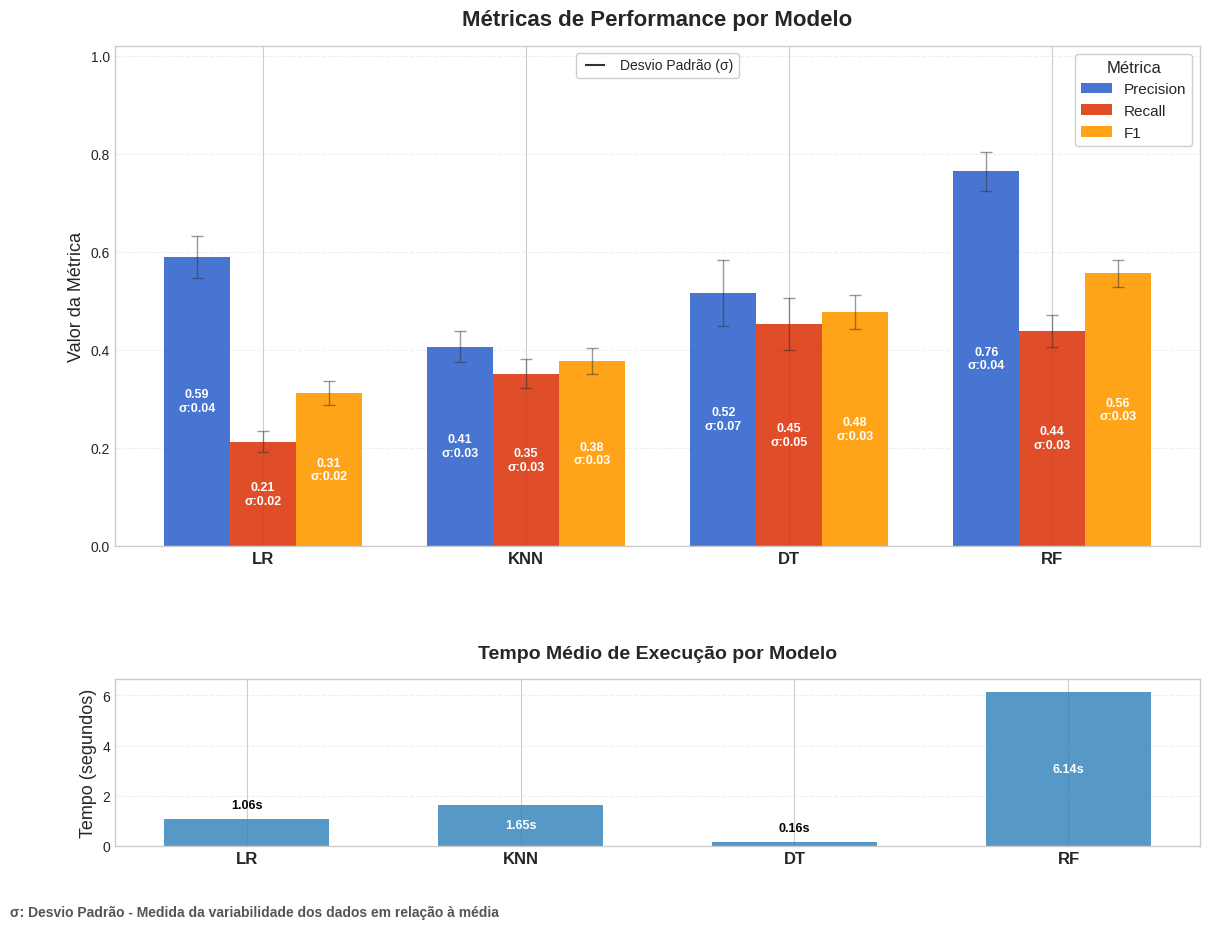

In [ ]:
#@title Gráfico Combinado de Métricas e Tempo de Execução

import matplotlib.lines as mlines
# Configuração visual para gráfico combinado de performance e tempo com rótulos melhorados
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1], gridspec_kw={'hspace': 0.4})

# Identificar as colunas de métricas
metrics_cols = []
if 'test_precision' in final_results.columns:
    metrics_cols = ['test_precision', 'test_recall', 'test_f1']
elif 'precision' in final_results.columns:
    metrics_cols = ['precision', 'recall', 'f1']
else:
    # Buscar pelo padrão
    precision_col = [col for col in final_results.columns if 'precision' in col.lower()]
    recall_col = [col for col in final_results.columns if 'recall' in col.lower()]
    f1_col = [col for col in final_results.columns if 'f1' in col.lower()]

    if precision_col and recall_col and f1_col:
        metrics_cols = [precision_col[0], recall_col[0], f1_col[0]]

if not metrics_cols:
    raise ValueError("Não foi possível identificar as colunas de métricas no DataFrame")

print("Colunas de métricas identificadas:", metrics_cols)

# Verificar se temos coluna de tempo
time_col = None
for col in final_results.columns:
    if 'time' in col.lower() or 'tempo' in col.lower() or 'duration' in col.lower():
        time_col = col
        break

if not time_col:
    print("Aviso: Coluna de tempo não encontrada. Simulando dados de tempo.")
    # Simular dados de tempo se não encontrarmos
    final_results['tempo_execucao'] = np.random.uniform(1, 5, size=len(final_results))
    time_col = 'tempo_execucao'

# Calcular médias e desvios padrão para cada modelo e métrica
model_stats = {}
for model in final_results['modelo'].unique():
    model_data = final_results[final_results['modelo'] == model]
    model_stats[model] = {
        'metrics': {},
        'time': {
            'mean': model_data[time_col].mean(),
            'std': model_data[time_col].std()
        }
    }

    for col in metrics_cols:
        model_stats[model]['metrics'][col] = {
            'mean': model_data[col].mean(),
            'std': model_data[col].std()
        }

# Preparar dados para o gráfico de métricas (painel superior)
models = list(model_stats.keys())
metrics_display = ['Precision', 'Recall', 'F1']
colors = ['#3366CC', '#DC3912', '#FF9900']  # Azul, Vermelho, Laranja

# Largura das barras
bar_width = 0.25
index = np.arange(len(models))

# Função para adicionar rótulos dentro das barras quando possível
def add_value_label(ax, bars, values, stds, color='white'):
    for bar, value, std in zip(bars, values, stds):
        height = bar.get_height()

        # Se a barra for alta o suficiente, coloque o texto dentro
        if height > 0.15:
            # Valor principal dentro da barra
            ax.text(bar.get_x() + bar.get_width()/2, height/2,
                    f'{value:.2f}\nσ:{std:.2f}',
                    ha='center', va='center', color=color,
                    fontsize=9, fontweight='bold')
        else:
            # Valor principal acima da barra se for muito baixa
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                    f'{value:.2f}\nσ:{std:.2f}',
                    ha='center', va='bottom', color='black',
                    fontsize=9, fontweight='bold')

# Plotar barras para cada métrica
for i, (metric_col, metric_name) in enumerate(zip(metrics_cols, metrics_display)):
    means = [model_stats[model]['metrics'][metric_col]['mean'] for model in models]
    stds = [model_stats[model]['metrics'][metric_col]['std'] for model in models]

    position = index + (i-1) * bar_width
    bars = ax1.bar(position, means, bar_width, label=metric_name, color=colors[i], alpha=0.9)

    # Adicionar barras de erro
    ax1.errorbar(position, means, yerr=stds, fmt='none', capsize=4,
                 ecolor='#333333', capthick=1, elinewidth=1, alpha=0.5)

    # Adicionar rótulos alinhados com as barras
    add_value_label(ax1, bars, means, stds)

# Configurar o painel superior (métricas)
ax1.set_title('Métricas de Performance por Modelo', fontsize=16, fontweight='bold', pad=15)
ax1.set_xticks(index)
ax1.set_xticklabels(models, fontsize=12, fontweight='bold')
ax1.set_ylabel('Valor da Métrica', fontsize=13)
ax1.set_ylim(0, 1.02)  # Ajustado para evitar cortes

# Adicionar legenda de métricas
metrics_legend = ax1.legend(title='Métrica', fontsize=11, title_fontsize=12,
          loc='upper right', frameon=True, framealpha=0.95)

# Criar um elemento de linha para representar o desvio padrão
std_line = mlines.Line2D([], [], color='#333333', marker='_', linestyle='None',
                          markersize=15, markeredgewidth=1.5, label='Desvio Padrão (σ)')

# Adicionar a legenda de desvio padrão abaixo da legenda principal
ax1.add_artist(metrics_legend)
ax1.legend(handles=[std_line], loc='upper center', frameon=True,
           framealpha=0.95, fontsize=10)

ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Plotar gráfico de tempo de execução (painel inferior)
time_means = [model_stats[model]['time']['mean'] for model in models]

# Calcular o máximo para ajustar a escala
max_time = max(time_means) + 0.5

time_bars = ax2.bar(index, time_means, width=0.6, color='#2C7FB8', alpha=0.8)

# Adicionar apenas os rótulos de tempo (sem desvio padrão)
for j, bar in enumerate(time_bars):
    height = bar.get_height()

    # Posicionar o texto dependendo da altura da barra
    if height > max_time * 0.2:  # Se a barra for alta o suficiente
        ax2.text(bar.get_x() + bar.get_width()/2, height/2,
                f'{height:.2f}s',
                ha='center', va='center', color='white',
                fontsize=9, fontweight='bold')
    else:
        ax2.text(bar.get_x() + bar.get_width()/2, height + max_time * 0.05,
                f'{height:.2f}s',
                ha='center', va='bottom', color='black',
                fontsize=9, fontweight='bold')

# Configurar o painel inferior (tempo)
ax2.set_title('Tempo Médio de Execução por Modelo', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(index)
ax2.set_xticklabels(models, fontsize=12, fontweight='bold')
ax2.set_ylabel('Tempo (segundos)', fontsize=13)
ax2.set_ylim(0, max_time)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Adicionar texto explicativo sobre desvio padrão
fig.text(0.05, 0.01, 'σ: Desvio Padrão - Medida da variabilidade dos dados em relação à média',
         fontsize=10, fontweight='bold', color='#555555')

plt.tight_layout()
# Ajustar margens inferiores para acomodar o texto explicativo
plt.subplots_adjust(bottom=0.08)
plt.show()

Coluna de F1 identificada: f1


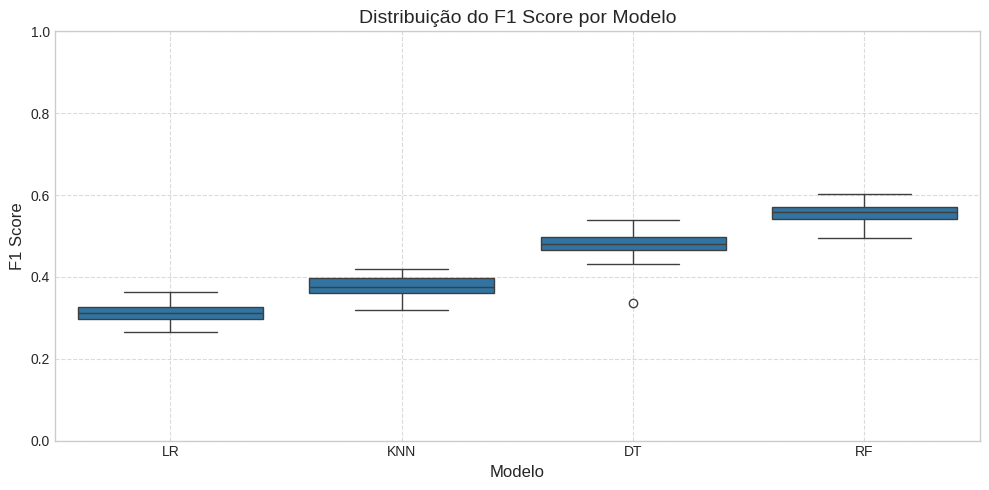

In [ ]:
# @title Boxplots da Distribuição do F1 Score por Modelo
plt.figure(figsize=(10, 5))

# Identificar a coluna de F1
f1_col = None
if 'test_f1' in final_results.columns:
    f1_col = 'test_f1'
elif 'f1' in final_results.columns:
    f1_col = 'f1'
else:
    # Buscar pelo padrão
    f1_candidates = [col for col in final_results.columns if 'f1' in col.lower()]
    if f1_candidates:
        f1_col = f1_candidates[0]

if not f1_col:
    raise ValueError("Não foi possível encontrar a coluna de F1 score")

print(f"Coluna de F1 identificada: {f1_col}")

# Criar o boxplot
sns.boxplot(x='modelo', y=f1_col, data=final_results)
plt.title('Distribuição do F1 Score por Modelo', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Colunas de métricas identificadas: ['precision', 'recall', 'f1']


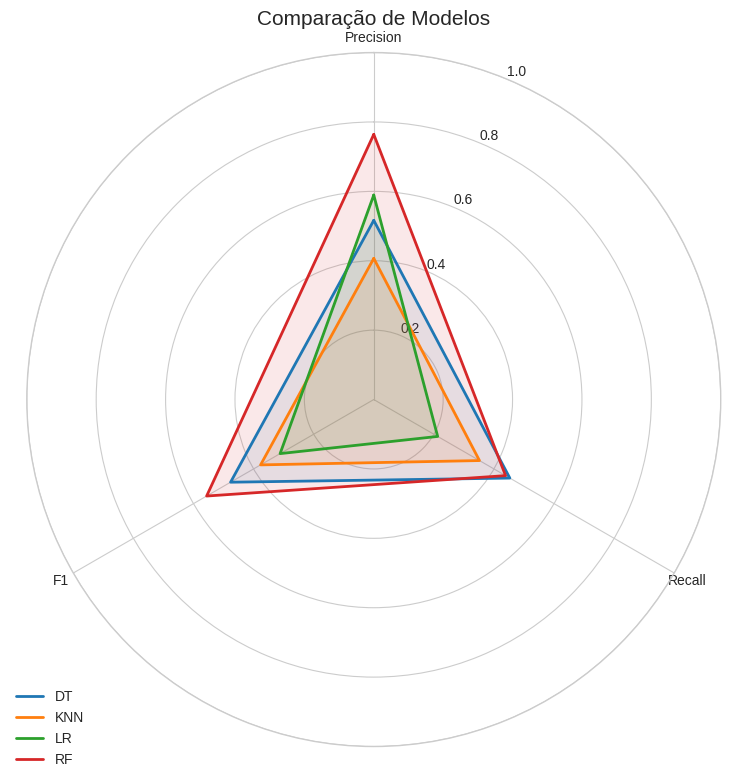

In [ ]:
# @title Gráfico Radar para Comparação de Modelos
# Identificar as colunas de métricas
metrics_cols = []
if 'test_precision' in final_results.columns:
    metrics_cols = ['test_precision', 'test_recall', 'test_f1']
elif 'precision' in final_results.columns:
    metrics_cols = ['precision', 'recall', 'f1']
else:
    # Buscar pelo padrão
    precision_col = [col for col in final_results.columns if 'precision' in col.lower()]
    recall_col = [col for col in final_results.columns if 'recall' in col.lower()]
    f1_col = [col for col in final_results.columns if 'f1' in col.lower()]

    if precision_col and recall_col and f1_col:
        metrics_cols = [precision_col[0], recall_col[0], f1_col[0]]

if not metrics_cols:
    raise ValueError("Não foi possível identificar as colunas de métricas")

print("Colunas de métricas identificadas:", metrics_cols)

# Preparar dados normalizados para cada métrica
metrics_df = final_results.groupby("modelo")[metrics_cols].mean()

# Nomes para exibição
metrics_display = ['Precision', 'Recall', 'F1']

# Configuração do gráfico radar
categories = metrics_display
N = len(categories)

# Ângulos do eixo
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Fechar o círculo

# Plotar em um gráfico polar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Para cada modelo, plotar as métricas
for modelo in metrics_df.index:
    values = metrics_df.loc[modelo].values.tolist()
    values += values[:1]  # Fechar o polígono

    # Plotar o polígono
    ax.plot(angles, values, linewidth=2, label=modelo)
    ax.fill(angles, values, alpha=0.1)

# Ajustar o eixo
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Comparação de Modelos', fontsize=15, pad=20)
plt.tight_layout()
plt.show()

Colunas de métricas identificadas: ['precision', 'recall', 'f1']


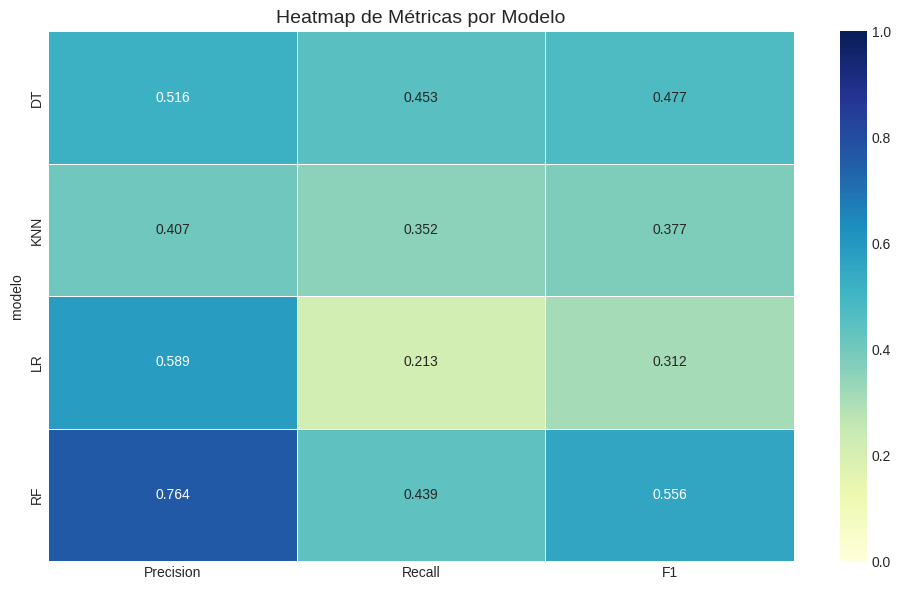

In [ ]:
# @title Heatmap de Métricas de Performance

# Identificar as colunas de métricas
metrics_cols = []
if 'test_precision' in final_results.columns:
    metrics_cols = ['test_precision', 'test_recall', 'test_f1']
elif 'precision' in final_results.columns:
    metrics_cols = ['precision', 'recall', 'f1']
else:
    # Buscar pelo padrão
    precision_col = [col for col in final_results.columns if 'precision' in col.lower()]
    recall_col = [col for col in final_results.columns if 'recall' in col.lower()]
    f1_col = [col for col in final_results.columns if 'f1' in col.lower()]

    if precision_col and recall_col and f1_col:
        metrics_cols = [precision_col[0], recall_col[0], f1_col[0]]

if not metrics_cols:
    raise ValueError("Não foi possível identificar as colunas de métricas")

print("Colunas de métricas identificadas:", metrics_cols)

plt.figure(figsize=(10, 6))

# Preparar dados para o heatmap
metrics_df = final_results.groupby("modelo")[metrics_cols].mean()

# Renomear colunas para melhor apresentação
metrics_df.columns = ['Precision', 'Recall', 'F1']

# Criar o heatmap
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', linewidths=.5,
            fmt='.3f', vmin=0, vmax=1)

plt.title('Heatmap de Métricas por Modelo', fontsize=14)
plt.tight_layout()
plt.show()

Colunas de métricas identificadas: ['precision', 'recall', 'f1']


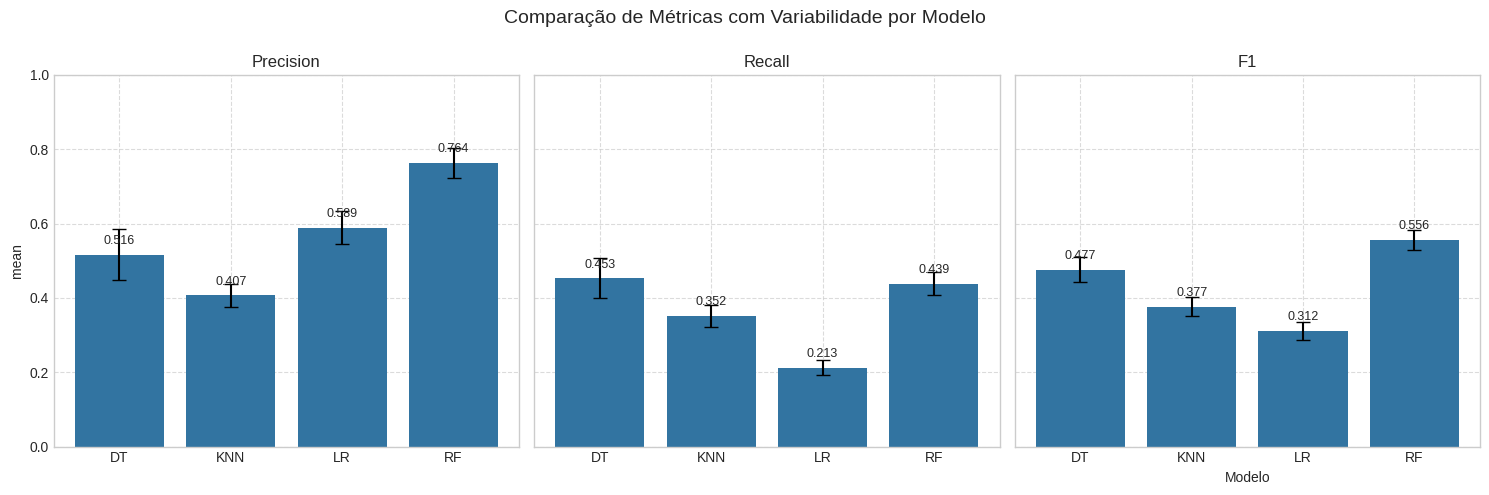

In [ ]:
# @title Visualização Combinada de Métricas e Variabilidade

# Identificar as colunas de métricas
metrics_cols = []
if 'test_precision' in final_results.columns:
    metrics_cols = ['test_precision', 'test_recall', 'test_f1']
elif 'precision' in final_results.columns:
    metrics_cols = ['precision', 'recall', 'f1']
else:
    # Buscar pelo padrão
    precision_col = [col for col in final_results.columns if 'precision' in col.lower()]
    recall_col = [col for col in final_results.columns if 'recall' in col.lower()]
    f1_col = [col for col in final_results.columns if 'f1' in col.lower()]

    if precision_col and recall_col and f1_col:
        metrics_cols = [precision_col[0], recall_col[0], f1_col[0]]

if not metrics_cols:
    raise ValueError("Não foi possível identificar as colunas de métricas")

print("Colunas de métricas identificadas:", metrics_cols)

# Nomes para display
metrics_display = ['Precision', 'Recall', 'F1']

# Configuração do gráfico
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Métricas a serem plotadas
for i, (metric_col, metric_name) in enumerate(zip(metrics_cols, metrics_display)):
    # Agregação dos dados
    grouped_data = final_results.groupby('modelo')[metric_col].agg(['mean', 'std']).reset_index()

    # Criar o gráfico de barras com barras de erro
    bars = sns.barplot(x='modelo', y='mean', data=grouped_data, ax=axes[i])

    # Adicionar barras de erro
    for j, bar in enumerate(bars.patches):
        # Altura da barra
        height = bar.get_height()
        # Erro padrão
        error = grouped_data.iloc[j]['std']
        # Adicionar barras de erro
        axes[i].errorbar(bar.get_x() + bar.get_width()/2, height,
                    yerr=error, fmt='none', color='black', capsize=5)

        # Adicionar valor na barra
        axes[i].text(bar.get_x() + bar.get_width()/2,
                height + 0.02, f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

    # Configuração do gráfico
    axes[i].set_title(f'{metric_name}', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.7)

    # Remover rótulos x exceto no último gráfico
    if i < 2:
        axes[i].set_xlabel('')
    else:
        axes[i].set_xlabel('Modelo', fontsize=10)

# Adicionar título global
plt.suptitle('Comparação de Métricas com Variabilidade por Modelo', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Conclusão

Observando os resultados da validação cruzada, podemos concluir que o modelo Random Forest (RF) apresentou o melhor desempenho preditivo geral entre os modelos testados. Em termos da métrica F1-score, que busca um equilíbrio entre precisão e recall, o RF obteve a maior média (aproximadamente 0,63) e um desvio padrão relativamente baixo (cerca de 0,02). Isso indica que o modelo é capaz de classificar corretamente uma porcentagem significativa dos casos de churn, ao mesmo tempo que minimiza os falsos positivos e falsos negativos.

O modelo de Regressão Logística (LR) também apresentou um bom desempenho, com uma média de F1-score próxima a 0,61 e um desvio padrão similar ao RF. Adicionalmente, o LR se destaca por sua simplicidade e interpretabilidade, tornando-o uma opção interessante para cenários onde a explicabilidade do modelo é crucial.

Em contraste, os modelos K-Nearest Neighbors (KNN) e Decision Tree (DT) obtiveram resultados inferiores em termos de F1-score. O KNN apresentou uma média em torno de 0,58, enquanto o DT ficou em torno de 0,56. Esses resultados sugerem que esses modelos podem não ser tão adequados para o problema em questão, em comparação com o RF e o LR.

Em relação à estabilidade dos modelos, podemos observar que o RF e o LR apresentaram os menores desvios padrão nas métricas de avaliação, indicando maior robustez e menor sensibilidade à variação nos dados de treinamento. O KNN e o DT, por sua vez, apresentaram desvios padrão maiores, sugerindo que seus desempenhos podem ser mais influenciados pela divisão dos dados.

Com a análise realizada, concluímos que o modelo Random Forest (RF) se destaca como a melhor opção para a predição de churn neste conjunto de dados, considerando o equilíbrio entre desempenho preditivo e estabilidade. No entanto, a Regressão Logística (LR) também se mostra como uma alternativa viável, em cenários onde a interpretabilidade do modelo seria prioritária.
